In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import GaussianMixture

from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [11]:
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

## Load data 

In [12]:
data_path = "./creditcard.csv"
data = pd.read_csv(data_path)
data.Time = data.Time.astype(int)  # Always positive natural numbers
data["Class"] = data["Class"].astype(int)
data.drop(["Time"], axis=1, inplace=True)

## Preprocess data 

#### Subset of data (easy data) 

In [13]:
# Subset of the data
train_ratio = 0.5
normal_to_anomaly_ratio = 4
fraud_percentile = 100 / (normal_to_anomaly_ratio * train_ratio + 1)

print("Frauds percentage in test: {}%".format(fraud_percentile))

frauds = data[data["Class"] == 1]
non_frauds = (data[data["Class"] == 0]).sample(n=(normal_to_anomaly_ratio * len(frauds)), random_state=RANDOM_SEED)
easy_data = pd.concat([non_frauds, frauds])
scaler = StandardScaler()
easy_data["Amount"] = scaler.fit_transform(easy_data["Amount"].values.reshape(-1, 1))

print("Number of data samples: {}".format(len(easy_data)))

Frauds percentage in test: 33.333333333333336%
Number of data samples: 2460


#### Whole data 

In [14]:
# All the data
train_ratio = 0.5
normal_to_anomaly_ratio = (492 / 284807) ** -1
fraud_percentile = 100 * (492 / 284807)

print("Frauds percentage in test: {}%".format(fraud_percentile))

# Normalize Amount
scaler = StandardScaler()
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

print("Number of data samples: {}".format(len(data)))

Frauds percentage in test: 0.1727485630620034%
Number of data samples: 284807


## Split train/test 

In [15]:
labels = data["Class"].to_numpy()
features = data.iloc[:, :-1].to_numpy()

frauds_data = features[labels == 1]
frauds_labels = labels[labels == 1]

normal_data = features[labels == 0]
normal_labels = labels[labels == 0]

nb_normal_samples = normal_data.shape[0]
rand_idx = np.arange(nb_normal_samples)
np.random.shuffle(rand_idx)
split_index = int(nb_normal_samples * train_ratio)

# Train set is non-frauds only in order to learn what is a normal reconstruction error
X_train = normal_data[rand_idx[:split_index]]
y_train = normal_labels[rand_idx[:split_index]]

# Test set is a mix of non-frauds and all the frauds (reconstruction error should be higher on those)
X_test = normal_data[rand_idx[split_index:]]  # Non-frauds according to train/test split ratio
y_test = normal_labels[rand_idx[split_index:]]

X_test = np.concatenate((X_test, frauds_data), axis=0)  # Add frauds
y_test = np.concatenate((y_test, frauds_labels), axis=0)

print("Number of training samples (non frauds only): {}".format(len(X_train)))
print("Number of test samples (with the 492 frauds): {}".format(len(X_test)))

Number of training samples (non frauds only): 142157
Number of test samples (with the 492 frauds): 142650


# PCA + GMM

## 1D projection

In [16]:
pca = PCA(n_components=1, random_state=RANDOM_SEED)
gmm = GaussianMixture(n_components=2, random_state=RANDOM_SEED)

# Train
start = time()
reduced_dim_X_train = pca.fit_transform(X_train)
gmm.fit(reduced_dim_X_train)
end = time()
print("Training time: {:.4f}s".format((end - start)))

# Test
reduced_dim_X_test = pca.transform(X_test)
print("Reduced test set shape: {}".format(reduced_dim_X_test.shape))
pred = gmm.predict(reduced_dim_X_test)
# pred = np.where(pred < 1, pred, 1)  # If using more than 2 components
print("Predicted unique classes: {}".format(np.unique(pred)))

Training time: 0.6244s
Reduced test set shape: (142650, 1)
Predicted unique classes: [0 1]


In [17]:
accuracy = accuracy_score(y_test, pred)
precision, recall, f_score, support = precision_recall_fscore_support(y_test, pred, average='binary')
print("Accuracy: {:0.4f}, Precision: {:0.4f}, Recall: {:0.4f}, F-score: {:0.4f}".format(accuracy, precision, recall, f_score))
print("Confusion matrix (truth on the lines)")
print(confusion_matrix(y_test, pred))
print("Classification Report")
print(classification_report(y_test, pred, target_names=["Normal", "Fraud"], digits=4))

Accuracy: 0.9506, Precision: 0.0222, Recall: 0.3089, F-score: 0.0414
Confusion matrix (truth on the lines)
[[135451   6707]
 [   340    152]]
Classification Report
              precision    recall  f1-score   support

      Normal     0.9975    0.9528    0.9746    142158
       Fraud     0.0222    0.3089    0.0414       492

   micro avg     0.9506    0.9506    0.9506    142650
   macro avg     0.5098    0.6309    0.5080    142650
weighted avg     0.9941    0.9506    0.9714    142650



<IPython.core.display.Javascript object>


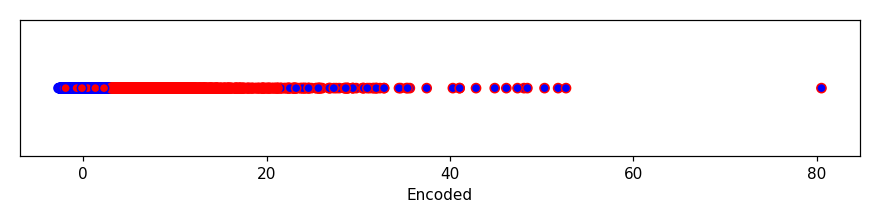

In [18]:
pred_colors = np.where(pred == 1, "r", "b")

y_plot = np.ones(len(reduced_dim_X_test))
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax.scatter(reduced_dim_X_test, y_plot, c=y_test.astype(int), edgecolor=pred_colors, cmap="bwr")
ax.set_xlabel('Encoded')
ax.set_yticks([])
plt.tight_layout()
plt.show()

# 3D projection

In [19]:
pca = PCA(n_components=3, random_state=RANDOM_SEED)
gmm = GaussianMixture(n_components=2, random_state=RANDOM_SEED)

# Train
start = time()
reduced_dim_X_train = pca.fit_transform(X_train)
gmm.fit(reduced_dim_X_train)
end = time()
print("Training time: {:.4f}s".format((end - start)))

# Test
reduced_dim_X_test = pca.transform(X_test)
print("Reduced test set shape: {}".format(reduced_dim_X_test.shape))
pred = gmm.predict(reduced_dim_X_test)
# pred = np.where(pred < 1, pred, 1)  # If using more than 2 components
print("Predicted unique classes: {}".format(np.unique(pred)))

Training time: 1.0368s
Reduced test set shape: (142650, 3)
Predicted unique classes: [0 1]


In [20]:
accuracy = accuracy_score(y_test, pred)
precision, recall, f_score, support = precision_recall_fscore_support(y_test, pred, average='binary')
print("Accuracy: {:0.4f}, Precision: {:0.4f}, Recall: {:0.4f}, F-score: {:0.4f}".format(accuracy, precision, recall, f_score))
print("Confusion matrix (truth on the lines)")
print(confusion_matrix(y_test, pred))
print("Classification Report")
print(classification_report(y_test, pred, target_names=["Normal", "Fraud"], digits=4))

Accuracy: 0.4102, Precision: 0.0050, Recall: 0.8516, F-score: 0.0099
Confusion matrix (truth on the lines)
[[58092 84066]
 [   73   419]]
Classification Report
              precision    recall  f1-score   support

      Normal     0.9987    0.4086    0.5800    142158
       Fraud     0.0050    0.8516    0.0099       492

   micro avg     0.4102    0.4102    0.4102    142650
   macro avg     0.5019    0.6301    0.2949    142650
weighted avg     0.9953    0.4102    0.5780    142650



<IPython.core.display.Javascript object>


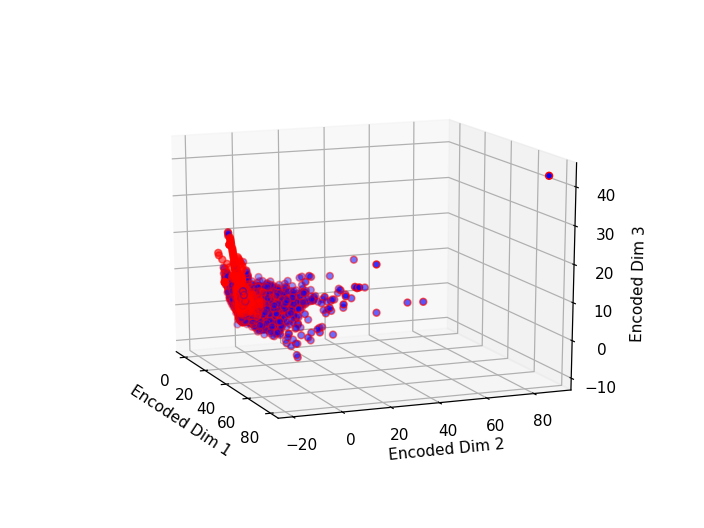

In [21]:
pred_colors = np.where(pred == 1, "r", "b")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(reduced_dim_X_test[:, 0], reduced_dim_X_test[:, 1], reduced_dim_X_test[:, 2], c=y_test.astype(int), edgecolor=pred_colors, cmap="bwr")
ax.set_xlabel('Encoded Dim 1')
ax.set_ylabel('Encoded Dim 2')
ax.set_zlabel('Encoded Dim 3')
plt.show()

## Isomap 

Memory error

In [17]:
from sklearn.manifold import Isomap

iso = Isomap(n_components=3)
start = time()
reduced_dim_X_train = iso.fit_transform(X_train)
end = time()
print("Training time: {:.4f}s".format((end - start)))

reduced_dim_X_test = iso.transform(X_test)
print("Reduced test set shape: {}".format(reduced_dim_X_test.shape))

MemoryError: 

## T-SNE 

Memory error

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=RANDOM_SEED)

reduced_dim_X_train = tsne.fit_transform(X_train)
reduced_dim_X_test = tsne.transform(X_test)

print("Reduced train set shape: {}".format(reduced_dim_X_train.shape))
print("Reduced test set shape: {}".format(reduced_dim_X_test.shape))

# Dim reduction with recon error and GMM 

## PCA + Recon error + GMM 

In [22]:
def relative_euclidean_distance(a, b):
    return np.linalg.norm(a - b) / np.linalg.norm(a)

In [23]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

#### Train

In [24]:
pca = PCA(n_components=1, random_state=RANDOM_SEED)
gmm = GaussianMixture(n_components=2, random_state=RANDOM_SEED)

start = time()

# PCA
reduced_dim_X_train = pca.fit_transform(X_train)
print("Compressed train set shape: {}".format(reduced_dim_X_train.shape))
recon_X_train = pca.inverse_transform(reduced_dim_X_train)

# Recon error
# Euclidean
rec_euclidean_train = np.array([relative_euclidean_distance(X_train[i], recon_X_train[i]) for i in range(len(X_train))])
rec_euclidean_train = np.reshape(rec_euclidean_train, (-1, 1))
# Cosine
rec_cosine_train = np.array([cosine_similarity(X_train[i], recon_X_train[i]) for i in range(len(X_train))])
rec_cosine_train = np.reshape(rec_cosine_train, (-1, 1))

# Concatenate to obtain z
Z_train = np.hstack((reduced_dim_X_train, rec_euclidean_train, rec_cosine_train))
print("Reduced dim train set shape: {}".format(Z_train.shape))

# Estimate GMM parameters
gmm.fit(Z_train)

end = time()
print("Training time: {:.4f}s".format((end - start)))

Compressed train set shape: (142157, 1)
Reduced dim train set shape: (142157, 3)
Training time: 3.6997s


#### Test 

In [25]:
# PCA
reduced_dim_X_test = pca.transform(X_test)
print("Compressed test set shape: {}".format(reduced_dim_X_test.shape))
recon_X_test = pca.inverse_transform(reduced_dim_X_test)

# Recon error
# Euclidean
rec_euclidean_test = np.array([relative_euclidean_distance(X_test[i], recon_X_test[i]) for i in range(len(X_test))])
rec_euclidean_test = np.reshape(rec_euclidean_test, (-1, 1))
# Cosine
rec_cosine_test = np.array([cosine_similarity(X_test[i], recon_X_test[i]) for i in range(len(X_test))])
rec_cosine_test = np.reshape(rec_cosine_test, (-1, 1))

# Concatenate to obtain z
Z_test = np.hstack((reduced_dim_X_test, rec_euclidean_test, rec_cosine_test))
print("Reduced dim test set shape: {}".format(Z_test.shape))

# Comute sample energy and threshold with GMM
train_energy = -gmm.score_samples(Z_train)
test_energy = -gmm.score_samples(Z_test)
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
thresh = np.percentile(combined_energy, 100 - fraud_percentile)
print("Fraud percentile: {:.6f} - Threshold: {:.4f}".format(fraud_percentile, thresh))

Compressed test set shape: (142650, 1)
Reduced dim test set shape: (142650, 3)
Fraud percentile: 0.172749 - Threshold: 35.8793


#### Predict classes and show results 

In [26]:
pred = (test_energy > thresh).astype(int)

accuracy = accuracy_score(y_test, pred)
precision, recall, f_score, support = precision_recall_fscore_support(y_test, pred, average='binary')
print("Accuracy: {:0.4f}, Precision: {:0.4f}, Recall: {:0.4f}, F-score: {:0.4f}".format(accuracy, precision, recall, f_score))
print("Confusion matrix (truth on the lines)")
print(confusion_matrix(y_test, pred))
print("Classification Report")
print(classification_report(y_test, pred, target_names=["Normal", "Fraud"], digits=4))

Accuracy: 0.9951, Precision: 0.0658, Recall: 0.0325, F-score: 0.0435
Confusion matrix (truth on the lines)
[[141931    227]
 [   476     16]]
Classification Report
              precision    recall  f1-score   support

      Normal     0.9967    0.9984    0.9975    142158
       Fraud     0.0658    0.0325    0.0435       492

   micro avg     0.9951    0.9951    0.9951    142650
   macro avg     0.5313    0.5155    0.5205    142650
weighted avg     0.9934    0.9951    0.9942    142650



<IPython.core.display.Javascript object>


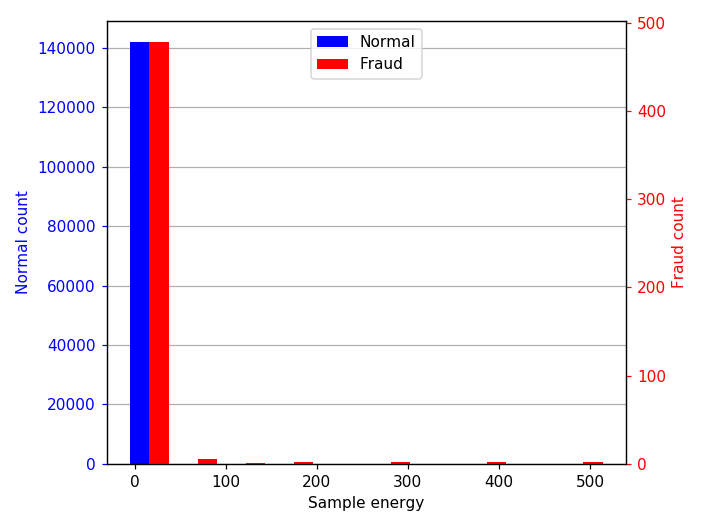

In [27]:
# Plot the histograms of the energy of the normal and frauds samples
# Sets up the axis and gets histogram data
colors = ["blue", "red"]
fig = plt.figure()
ax1 = fig.add_subplot(111)
n, bins, patches = ax1.hist([test_energy[y_test == 0], test_energy[y_test == 1]], color=colors)
ax1.cla()  # clear the axis
# Plots the histogram data
width = (bins[1] - bins[0]) * 0.4
bins_shifted = bins + width
ax1.grid(axis="y", zorder=1)
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0], zorder=2, label="Normal")
ax2 = ax1.twinx()
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1], label="Fraud")
# Create combined legend
bars1, lab1 = ax1.get_legend_handles_labels()
bars2, lab2 = ax2.get_legend_handles_labels()
ax2.legend(bars1 + bars2, lab1 + lab2, loc='upper center')
# Finish the plot
ax1.set_ylabel("Normal count", color=colors[0])
ax2.set_ylabel("Fraud count", color=colors[1])
ax1.set_xlabel("Sample energy")
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


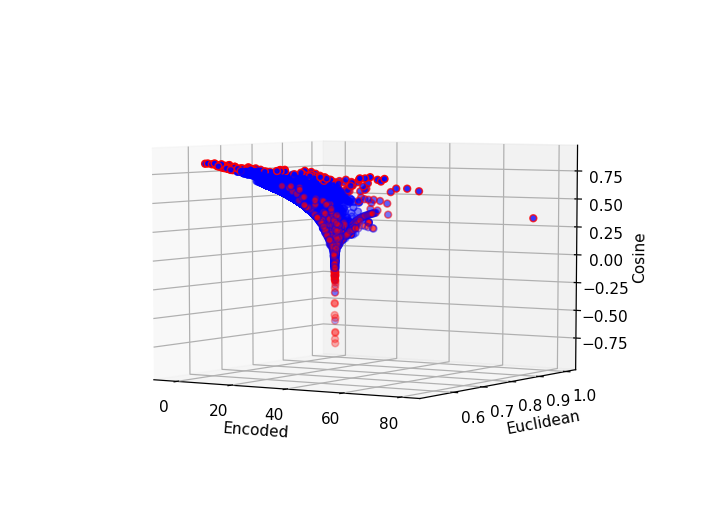

In [28]:
pred_colors = np.where(pred == 1, "r", "b")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z_test[:, 0], Z_test[:, 1], Z_test[:, 2], c=y_test.astype(int), edgecolors=pred_colors, cmap="bwr")
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

## Kernel PCA + Recon error + GMM 

Memory Error

#### PCA encoding and decoding 

In [52]:
kpca = KernelPCA(n_components=1, kernel="rbf", eigen_solver="arpack", random_state=RANDOM_SEED)

reduced_dim_X_train = kpca.fit_transform(X_train)
reduced_dim_X_test = kpca.transform(X_test)

print("Reduced train set shape: {}".format(reduced_dim_X_train.shape))
print("Reduced test set shape: {}".format(reduced_dim_X_test.shape))

recon_X_train = kpca.inverse_transform(reduced_dim_X_train)
recon_X_test = kpca.inverse_transform(reduced_dim_X_test)

MemoryError: 